# Pretraining a Born Classifier

We'd like to extract as much performance form Born as possible, without complicating the model (we've seen that ensembling is not particularly effective anyhow, see the `born_ensemble.ipynb` notebook).

Pretraining seems like a natural way to go about it!

In [179]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt 
import seaborn as sns

from bornrule import BornClassifier

from utils import prepare_data

## Data preparation

In [180]:
datadir = "data"
df_in = pd.read_parquet(os.path.join(datadir, "pretrain.parquet"))

df_out = prepare_data(df_in, num_processes=5)

[+] Loading data from prepared.parquet.


In [181]:
df_out.sample(15)

,sentence_id,token,pos,dep,ner_tag
27627592,1,industry,NOUN,pobj,NONE
31599827,2,of,ADP,prep,NONE
4625383,2,resignation,NOUN,pobj,NONE
27590174,0,of,ADP,prep,LOC
16319658,4,1873,NUM,pobj,DATE
19931856,0,(,PUNCT,punct,NONE
26671890,0,Mu,PROPN,compound,PERSON
4668856,3,short,ADJ,amod,NONE
9859573,0,Calì,PROPN,nsubj,ORG
8040887,13,honoris,PROPN,compound,ORG


In [182]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35824413 entries, 0 to 35824412
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   sentence_id  int64 
 1   token        object
 2   pos          object
 3   dep          object
 4   ner_tag      object
dtypes: int64(1), object(4)
memory usage: 1.3+ GB


In [183]:
df_out['ner_tag'].value_counts()

ner_tag
NONE           26635602
ORG             2460284
PERSON          1723805
DATE            1662194
GPE             1188244
CARDINAL         425493
NORP             370960
LOC              271220
WORK_OF_ART      215003
FAC              195547
QUANTITY         193367
EVENT            176207
ORDINAL          122088
PRODUCT           51924
TIME              30588
LAW               29359
MONEY             27780
PERCENT           23396
LANGUAGE          21352
Name: count, dtype: int64

## Data processing

We'll encode the categorical values more or less as in the CoNLL case, i.e., to ordinal ones instead of one-hot encoded ones.

In [184]:
cols_to_encode = set(df_out.columns) - {'sentence_id', 'token'}

In [185]:
encoded_cols = []
ordinal_mappings = {}
for col in cols_to_encode:
    ordinal_encoder = OrdinalEncoder(dtype=np.int8)
    encoded_col_and_name = (ordinal_encoder.fit_transform(df_out[[col]]), ordinal_encoder.get_feature_names_out()[0])
    encoded_cols.append(encoded_col_and_name)

    # keep track of the mappigs for later (note that the encoding proceeds in the order in which the features appear in the list => the first element is encoded as 0, the second as 1, etc.)
    ordinal_mappings[ordinal_encoder.get_feature_names_out()[0]] = ordinal_encoder.categories_[0]

In [186]:
columns_to_keep = ['sentence_id', 'token']

encoded_df = pd.DataFrame()
for encoded_col, column in encoded_cols:
    encoded_df[column] = encoded_col.flatten()

encoded_df = pd.concat([df_out[columns_to_keep], encoded_df], axis=1)

In [187]:
encoded_df.sample(15)

,sentence_id,token,pos,dep,ner_tag
29140568,3,.,12,41,9
27604679,8,the,5,20,9
15721912,9,1991,8,7,1
15299208,3,nominated,16,0,9
4689413,33,joining,16,3,9
2992434,2,'s,9,11,9
1651982,1,CRPF,11,30,9
16980977,6,:,12,41,9
23892402,0,2,8,31,0
11671125,0,is,3,0,9


Now we proceed as we did in the CoNLL notebook.

In [188]:
X_train_valid, X_test = train_test_split(encoded_df, test_size=0.15)
X_train, X_valid = train_test_split(X_train_valid, test_size=0.3)

In [189]:
y_train = X_train.ner_tag.to_list()
X_train = X_train.drop('ner_tag', axis=1)

y_valid = X_valid.ner_tag.to_list()
X_valid = X_valid.drop('ner_tag', axis=1)

y_test = X_test.ner_tag.to_list()
X_test = X_test.drop('ner_tag', axis=1)

In [190]:
X_train.head(8)

,sentence_id,token,pos,dep
6558302,1,Champaign,11,27
21807338,3,most,2,4
1222615,0,plan,7,35
6144407,1,",",12,41
20109095,0,15,8,31
19395564,1,Korea,11,7
1694450,7,1924–1927,11,31
24008288,13,Queen,11,14


In [191]:
X_train.to_dict('records')

[{'sentence_id': 1, 'token': 'Champaign', 'pos': 11, 'dep': 27},
 {'sentence_id': 3, 'token': 'most', 'pos': 2, 'dep': 4},
 {'sentence_id': 0, 'token': 'plan', 'pos': 7, 'dep': 35},
 {'sentence_id': 1, 'token': ',', 'pos': 12, 'dep': 41},
 {'sentence_id': 0, 'token': '15', 'pos': 8, 'dep': 31},
 {'sentence_id': 1, 'token': 'Korea', 'pos': 11, 'dep': 7},
 {'sentence_id': 7, 'token': '1924–1927', 'pos': 11, 'dep': 31},
 {'sentence_id': 13, 'token': 'Queen', 'pos': 11, 'dep': 14},
 {'sentence_id': 4, 'token': 'labyrinth', 'pos': 7, 'dep': 35},
 {'sentence_id': 0, 'token': '.', 'pos': 12, 'dep': 41},
 {'sentence_id': 1, 'token': 'and', 'pos': 4, 'dep': 12},
 {'sentence_id': 3, 'token': 'the', 'pos': 5, 'dep': 20},
 {'sentence_id': 3, 'token': 'contributions', 'pos': 7, 'dep': 7},
 {'sentence_id': 4, 'token': '1848', 'pos': 8, 'dep': 31},
 {'sentence_id': 0, 'token': 'and', 'pos': 4, 'dep': 12},
 {'sentence_id': 1, 'token': 'airline', 'pos': 7, 'dep': 30},
 {'sentence_id': 3, 'token': 'have

In [12]:
#! TODO: this might not be such a grand idea! => might be better to use a separate vectoriser fo the token column and then concat => otherwise I get confusion in the explain_df
dict_vec = DictVectorizer()

X_train = dict_vec.fit_transform(X_train.to_dict('records'))
X_val = dict_vec.transform(X_valid.to_dict('records'))
X_test = dict_vec.transform(X_test.to_dict('records'))

## Training

In [13]:
born = BornClassifier()
# 7.5s to train on ~36M tokens is quite impressive!
born.fit(X_train, y_train)

BornClassifier()

In [14]:
y_pred = born.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred, labels=np.unique(y_train)))

              precision    recall  f1-score   support

           0       0.46      0.31      0.37     63659
           1       0.93      0.39      0.55    249250
           2       0.37      0.53      0.44     26405
           3       0.31      0.19      0.24     29101
           4       0.75      0.49      0.59    177715
           5       0.51      0.90      0.65      3204
           6       0.01      0.27      0.02      4458
           7       0.11      0.48      0.18     40597
           8       0.02      0.63      0.04      4155
           9       0.98      0.46      0.63   3996861
          10       0.76      0.70      0.73     55573
          11       0.07      0.97      0.13     18321
          12       0.86      0.15      0.26    369346
          13       0.06      0.55      0.11      3489
          14       0.12      0.93      0.22    258373
          15       0.10      0.30      0.15      7728
          16       0.60      0.48      0.53     28953
          17       0.08    

A curious result.

Perhaps visualising the confusion matrix will tell us more!

In [31]:
labels = ordinal_mappings['ner_tag']
cm = confusion_matrix(y_test, y_pred, labels=range(len(labels), normalize='true'))

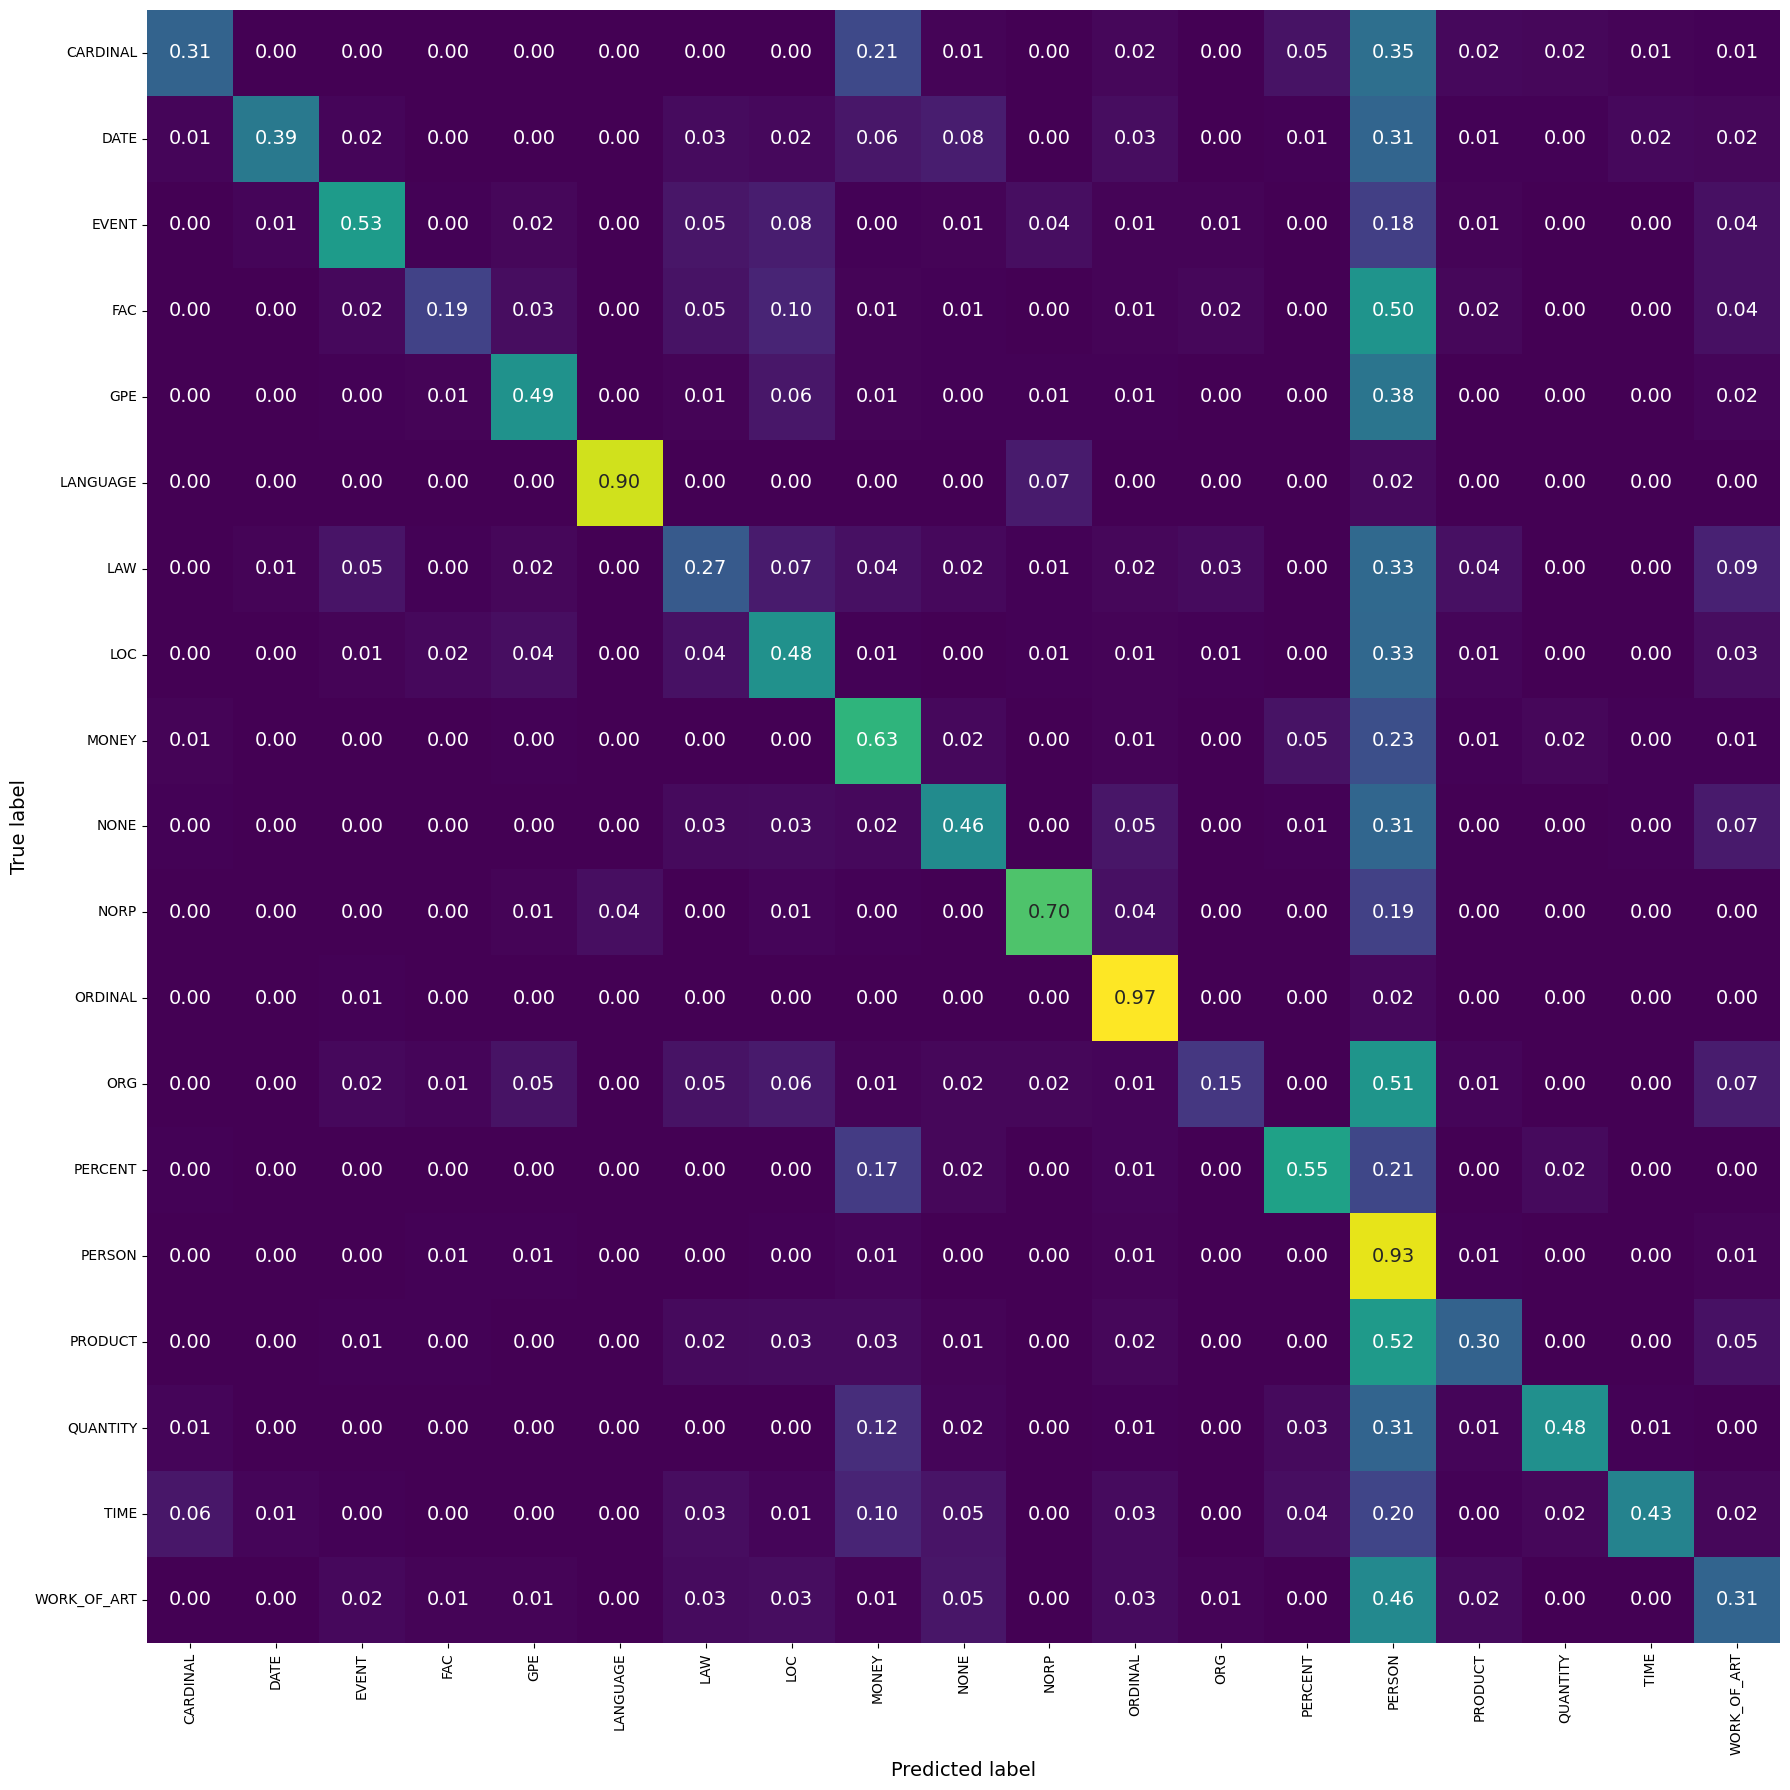

In [59]:
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(18, 18))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap='viridis', 
            xticklabels=labels, yticklabels=labels, 
            annot_kws={'size': 14}, cbar=False)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

plt.tight_layout()
plt.show()

This confusion matrix is actually quite a bit more heartening than the classification report: it's quite clear that the classifier has, in fact, learned something!

It's interesting to note that it seems to be the most confused about the `PERSON` tag.
Intuitively, this is not exceedingly surprising, especially when one looks at what person entities are most often confused with:
- `ORG`s (unsurprisingly, seeing as many organisations are named after people),
- `PRODUCT`s (for more or less the same reason as with organisations),
- `FAC`s (unsurprisingly, seeing as infrastructure is often named after people, e.g., the JFK Airport).

## Explanation 

In [60]:
features = dict_vec.get_feature_names_out()
columns = ordinal_mappings['ner_tag']
explain_df = pd.DataFrame(born.explain().toarray(), index=features, columns=columns)

In [178]:
features

array(['dep', 'pos', 'sentence_id', ..., 'token=𝔐', 'token=𝔭', 'token=𝛿'],
      dtype=object)

In [177]:
ordinal_mappings['ner_tag']

array(['CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW',
       'LOC', 'MONEY', 'NONE', 'NORP', 'ORDINAL', 'ORG', 'PERCENT',
       'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART'],
      dtype=object)

In [175]:
explain_df.loc['pos']

CARDINAL       0.008244
DATE           0.008206
EVENT          0.009946
FAC            0.009889
GPE            0.010292
LANGUAGE       0.007921
LAW            0.009232
LOC            0.009889
MONEY          0.008523
NONE           0.008631
NORP           0.006517
ORDINAL        0.003742
ORG            0.009832
PERCENT        0.007939
PERSON         0.010593
PRODUCT        0.009900
QUANTITY       0.008772
TIME           0.007872
WORK_OF_ART    0.009350
Name: pos, dtype: float64

Let's use the same example as in the `born_on_conll.ipynb` notebook.

In [171]:
explain_df.loc['token=EU'].sort_values(ascending=False)

ORG            0.001565
EVENT          0.001011
GPE            0.000559
WORK_OF_ART    0.000355
PERSON         0.000174
NONE           0.000061
LAW            0.000000
LOC            0.000000
MONEY          0.000000
DATE           0.000000
NORP           0.000000
ORDINAL        0.000000
LANGUAGE       0.000000
PERCENT        0.000000
FAC            0.000000
PRODUCT        0.000000
QUANTITY       0.000000
TIME           0.000000
CARDINAL       0.000000
Name: token=EU, dtype: float64

In [173]:
explain_df['PERSON'].sort_values(ascending=False).head(15)

token=John       0.013953
token=William    0.011382
pos              0.010593
token=Robert     0.010150
token=David      0.009705
token=James      0.009329
token=Michael    0.008877
token=Richard    0.008455
token=Peter      0.007675
token=Gmina      0.007537
token=George     0.007315
token=Thomas     0.007314
token=Charles    0.007170
token=Joseph     0.006795
token=Paul       0.006705
Name: PERSON, dtype: float64